# 2024 US Marathon Trials Viz 
Script for extracting, converting, and saving results from the 2024 USA Marathon Olympic Trials

In [7]:
import requests
import json
import os

import pandas as pd
import numpy as np
from datetime import datetime, timezone
import pytz

from scipy.interpolate import interp1d

flag_save = False

In [8]:
eastern_tz = pytz.timezone('America/New_York')
eastern_time = datetime.now(eastern_tz)

print("Local Time:", eastern_time.strftime('%Y-%m-%d %H:%M:%S %Z%z'))

Local Time: 2024-02-09 22:22:12 EST-0500


# Extract Results

In [9]:
# Function for converting API response to a table
# Takes the raw response as input
# Assumes that the data is in the `list` item 

def extract_results_table(_txt):
    
    _json = json.loads(_txt)
    _df = pd.DataFrame(_json['list'])

    return _df

In [10]:
payload = {
    'timesort': '1',
    'nohide': '1',
    'checksum': '', 
    'appid': '65328519e78ff0366f242153',
    'token': '0CB822ADFDC6C77C4394',
    'max': '999',
    'catloc': '1',
    'cattotal': '1',
    'units': 'standard',
    'source': 'webtracker'
}


In [11]:
# Build list of URLs

url_list = []    

url_base = 'https://api.rtrt.me/events/ORLANDO-TRIALS-2024/categories/top-{}-marathon/splits/{}M'

for g in ['men', 'women']:
    for i in range(1,27):
        url = url_base.format(g, i)
        url_list.append(url)

    url_list.append('https://api.rtrt.me/events/ORLANDO-TRIALS-2024/categories/top-{}-marathon/splits/FINISH'.format(g))

# Go get results!
    
list_results = []

for url in url_list:
    print(url)
    response = requests.post(url, data=payload)
    response_text = response.text
    response_code = response.status_code

    if response_code == 200:
        df_split_result = extract_results_table(response_text)
        list_results.append(df_split_result)

    else:

        print(response_code)
        print(response_text)  # Prints the response body

df_results = pd.concat(list_results, axis=0)

https://api.rtrt.me/events/ORLANDO-TRIALS-2024/categories/top-men-marathon/splits/1M
https://api.rtrt.me/events/ORLANDO-TRIALS-2024/categories/top-men-marathon/splits/2M


https://api.rtrt.me/events/ORLANDO-TRIALS-2024/categories/top-men-marathon/splits/3M
https://api.rtrt.me/events/ORLANDO-TRIALS-2024/categories/top-men-marathon/splits/4M
https://api.rtrt.me/events/ORLANDO-TRIALS-2024/categories/top-men-marathon/splits/5M
https://api.rtrt.me/events/ORLANDO-TRIALS-2024/categories/top-men-marathon/splits/6M
https://api.rtrt.me/events/ORLANDO-TRIALS-2024/categories/top-men-marathon/splits/7M
https://api.rtrt.me/events/ORLANDO-TRIALS-2024/categories/top-men-marathon/splits/8M
https://api.rtrt.me/events/ORLANDO-TRIALS-2024/categories/top-men-marathon/splits/9M
https://api.rtrt.me/events/ORLANDO-TRIALS-2024/categories/top-men-marathon/splits/10M
https://api.rtrt.me/events/ORLANDO-TRIALS-2024/categories/top-men-marathon/splits/11M
https://api.rtrt.me/events/ORLANDO-TRIALS-2024/categories/top-men-marathon/splits/12M
https://api.rtrt.me/events/ORLANDO-TRIALS-2024/categories/top-men-marathon/splits/13M
https://api.rtrt.me/events/ORLANDO-TRIALS-2024/categories/top

In [12]:
# Do some conversions
df_results['point'] = np.where(df_results['point']=='FINISH', '26.2M', df_results['point'])

df_results['distance'] = df_results['point'].str.slice(0, -1).astype(np.float64)

df_results['time_sec'] = pd.to_timedelta(df_results['time']).dt.total_seconds()
df_results['time_min'] = df_results['time_sec'] / 60.0

In [13]:
# Save raw results
if flag_save:
    print('Saving raw results')
    df_results.to_csv(os.path.join('..', 'public', 'data', 'result_raw_by_mile.csv'), index=False)
else:
    print('DID NOT SAVE')

DID NOT SAVE


In [68]:
# Extract final placing for each runner, so we can attach it to the results

# Final placing
df_results_final_by_runner = df_results.loc[df_results['isFinish']=='1', ['name', 'sex', 'place', 'isFinish']]

# Get info on DNFs
df_results_last_marker = df_results.groupby(['name', 'sex'], as_index=False).agg({'distance':'max', 'time_min':'max'})

# Combine:

df_results_runner_detail = df_results_last_marker.merge(df_results_final_by_runner, on=['name', 'sex'], how='left')

# Set place to a large number for non-finishers
# TODO: Make this smarter, based on distance covered
df_results_runner_detail['place'] = df_results_runner_detail['place'].fillna(999)
df_results_runner_detail['flag_finished'] = df_results_runner_detail['isFinish'].fillna(0).astype(np.int32)

df_results_runner_detail = df_results_runner_detail.rename(columns={'distance':'last_distance', 'time_min':'last_time', 'place':'final_place'})
df_results_runner_detail = df_results_runner_detail[['name', 'sex', 'flag_finished', 'last_distance', 'last_time', 'final_place']]

# Type conversions
df_results_runner_detail['final_place'] = df_results_runner_detail['final_place'].astype(np.int64)

In [70]:
# Append df_results_runner_detail to df_results:

df_results_full = df_results.merge(df_results_runner_detail, on=['name', 'sex'], how='left')


In [71]:
# pd.set_option('display.max_columns', None)
# df_results.sample(5)

flds = ['name', 'sex', 'bib_display', 'label', 'place', 'placeChange', 'isFinish', 'distance', 
        'time', 'time_sec', 'time_min', 'splitTime', 'netTime', 'waveTime', 'epochTime', 'timestamp', 
        'flag_finished', 'last_distance', 'last_time', 'final_place']

df_results_clean_men = df_results_full.loc[df_results_full['sex'] == 'M', flds]
df_results_clean_women = df_results_full.loc[df_results_full['sex'] == 'F', flds]
df_results_clean_all = df_results_full[flds]


In [72]:
# Save the raw results by mile:
# flag_save=True

if flag_save:
    print('Saving results by mile')
    df_results_clean_men.to_csv(os.path.join('..', 'public', 'data', 'result_men_by_mile.csv'), index=False)
    df_results_clean_women.to_csv(os.path.join('..', 'public', 'data', 'result_women_by_mile.csv'), index=False)
    df_results_clean_all.to_csv(os.path.join('..', 'public', 'data', 'result_all_by_mile.csv'), index=False)
else:
    print('DID NOT SAVE')

DID NOT SAVE


In [73]:
# Interpolate distances for fixed time intervals

In [74]:
def find_interpolated_distances(_df, new_x, fld_x='time_min', fld_y='distance'):
    '''
        _df: Dataframe of actual values; must contain the fields specified by: 
        fld_x: Name of field with x values
        fld_y: Name of field with y values
        new_x: List of new x values
    '''

    # We need to deal with non-finishers:
    #max_len = len(_df)
    new_x_trimmed = new_x #[:max_len]

    f = interp1d(_df[fld_x], _df[fld_y], kind='linear', bounds_error=False, fill_value="extrapolate")
    _estimated_distances = f(new_x_trimmed)
    
    # Let's make sure we cap things at the finish
    _estimated_distances = np.where(_estimated_distances > 26.2, 26.2, _estimated_distances)

    return _estimated_distances

In [75]:
def make_interpolated_results_table(_df, runner_name, time_values):
    '''
        _df: Table with fields including 'name', 'distance', 'time_min'
        runner_name: Name of runner that appears in the 'name' field
        time_values: List of time values for which we interpolate distance
    '''

    _df_sample = _df[_df['name'] == runner_name].copy().reset_index()

    # This is not elegant; it adds zero values so we have complete data from 0 to 26.2:
    _df_sample.loc[len(_df_sample)] = {'name': runner_name, 'distance': 0.0, 'time_min': 0.0}

    _distances = find_interpolated_distances(_df_sample, time_values, 'time_min', 'distance')

    # Make new df with results; trim the times for non-finishers

    _df_new = pd.DataFrame({'time_min': time_values[:len(_distances)], 'distance': _distances})
    _df_new['name'] = runner_name

    return _df_new

    

In [76]:
# Get list of runners

df_runners = df_results.groupby(['name', 'sex'], as_index=False).agg({'distance':'nunique', 'time_min':'max'})

In [77]:
# Loop through and estimate distances for specific time splits

step = 1.0

times = np.arange(0, 181, step).tolist()

list_df_distances = []

for i, r in df_runners.iterrows():
    print(r['name'], r['distance'])
    df_dist_tmp = make_interpolated_results_table(df_results, r['name'], times)
    #df_dist_tmp['gender'] = r['sex']
    df_dist_tmp['sex'] = r['sex']

    list_df_distances.append(df_dist_tmp)

df_distances = pd.concat(list_df_distances, axis=0)

# For debugging
df_distances_bak = df_distances.copy()

Aaron Davidson 13
Aaron Gruen 18
Abdi Abdirahman 8
Abigail McNulty 27
Abinet Adraro 15
Adam Sjolund 27
Adam Wollant 27
Adrian Walsh 27
Afewerki Zeru 27
Aidan Reed 27
Alan Peterson 27
Alberto Mena 27
Alex Norstrom 27
Alexander Burks 27
Alexander Taylor 18


Alexandra Greitzer 27
Aliphine Tuliamuk 10
Allie Schaich 27
Alyssa Bloomquist 17
Amanda Phillips 27
Amber Zimmerman 27
Amelia Keyser-Gibson 27
Amy Davis 27
Andrea Pomaranski 27
Andrew Bowman 17
Andrew Colley 19
Andrew McCann 27
Ann Marie Pierce 27
Ann Marie Tuxbury 27
Anna West 16
Anne-Marie Blaney 27
Annie Frisbie 27
Annie Heffernan 27
Ariane Hendrix 27
Ashlee Powers 27
Austin Bogina 27
Ava Nuttall 27
Awet Beraki 27
Ben Olson 18
Benjamin Decker 27
Benjamin Kendell 27
Benjamin Payne 27
Benjamin Schneiderman 27
Betsy Saina 22
Billie Hatch 24
Biya Simbassa 27
Bradley Taylor 12
Breanna Sieracki 27
Brendan Martin 27
Bria Wetsch 27
Brian Harvey 27
Brian Masterson 19
Brian Shrader 17
Bridget Lyons Belyeu 27
Britney Romero 27
Brittney Feivor 27
Brittney Hall 8
CJ Albertson 27
Caleb Kerr 27
Cameron Dickson 27
Caroline Cole 27
Caroline Rotich 27
Caroline Williams 27
Carrie Mack 18
Carrie Verdon 27
Chad Beyer 27
Charles Lawrence 14
Charlie Sweeney 27
Chase Weaverling 27
Christina Welsh 27
Claire

In [78]:
# Next, add  overall results

df_distances = df_distances.merge(df_results_runner_detail, on=['name', 'sex'], how='left')

# Handle cases where we've interpolated distances that are beyond the last known distance for non-finishers
df_distances['distance'] = np.minimum(df_distances['distance'], df_distances['last_distance'])


In [79]:
# Now compute the distance from 3rd 

def difference_from_nth_largest(group, n=3):
    # Find the 3rd largest distance in the group
    if len(group) >= n:
        nth_largest_distance = group['distance'].nlargest(n).iloc[-1]
    else:
        # If the group has less than 3 elements, use the smallest distance
        nth_largest_distance = group['distance'].min()
    
    # Compute the distance gap, assuming distance is miles!
    group['distance_diff_m'] = 1609.0 * (group['distance'] - nth_largest_distance)
    return group

# Apply the function to each group
df_distances = df_distances.groupby(['time_min', 'sex'], as_index=False).apply(difference_from_nth_largest, n=3)

df_distances['rank'] = df_distances.groupby(['time_min', 'sex'], as_index=False)['distance'].rank(method='min', ascending=False)

df_distances = df_distances.sort_values(['name', 'sex', 'time_min'])

In [80]:
# Compute estimated pace for each interval
# This is not the most elegant or efficient way to do this!!
df_tmp = df_distances[['name', 'sex', 'time_min', 'distance']].copy()
df_tmp['time_min_split'] = df_tmp['time_min']
df_tmp = df_tmp.set_index(['time_min', 'name', 'sex'])

df_diff = df_tmp.groupby(['name', 'sex']).diff()
df_diff = df_diff.reset_index()

df_diff['current_pace'] = df_diff['time_min_split'] / df_diff['distance']

df_distances = df_distances.merge(df_diff, on=['name', 'sex', 'time_min'], suffixes=['', '_split'])

# I don't understand why this column appears
#df_distances = df_distances.drop('index', axis=1, errors='ignore')

In [81]:
# Save the raw results by mile:

step_i = int(step)
if flag_save:
    print('Saving results by {} minute interval'.format(step_i))
    df_distances[df_distances['sex']=='M'].to_csv(os.path.join('..', 'public', 'data', 'result_men_by_{}min.csv'.format(step_i)), index=False)
    df_distances[df_distances['sex']=='F'].to_csv(os.path.join('..', 'public', 'data', 'result_women_by_{}min.csv'.format(step_i)), index=False)
    df_distances.to_csv(os.path.join('..', 'public', 'data', 'result_all_by_{}min.csv'.format(step_i)), index=False)
else:
    print('DID NOT SAVE')


DID NOT SAVE


In [82]:
df_distances.agg({'time_min':'max'})

time_min    180.0
dtype: float64

# Analysis


df_results.groupby('isFinish').agg({'name':'count'})

In [83]:
df_results_final_by_runner

,name,sex,place,isFinish
0,Conner Mantz,M,1,1
1,Clayton Young,M,2,1
2,Leonard Korir,M,3,1
3,Elkanah Kibet,M,4,1
4,CJ Albertson,M,5,1
...,...,...,...,...
112,Kir Selert Faraud,F,113,1
113,Ariane Hendrix,F,114,1
114,Johanna Butler,F,115,1
115,Tara Welling,F,116,1


In [84]:
df_results_last_marker.groupby(['sex', 'distance']).agg({'name':'nunique'})


name
sex distance      
F   6.0          2
    8.0          1
    10.0         4
    12.0         3
    13.0         1
    16.0         1
    17.0         3
    18.0         7
    19.0         2
    20.0         3
    21.0         2
    22.0         1
    24.0         1
    26.2       117
M   8.0          1
    9.0          1
    10.0         3
    11.0         3
    12.0         3
    13.0         5
    14.0         3
    15.0         3
    16.0         2
    17.0         5
    18.0         9
    19.0         4
    20.0         1
    21.0         4
    22.0         2
    24.0         1
    26.2       150

In [85]:
df_results_runner_detail

,name,sex,flag_finished,last_distance,last_time,final_place
0,Aaron Davidson,M,0,13.0,69.296833,999
1,Aaron Gruen,M,0,18.0,92.631000,999
2,Abdi Abdirahman,M,0,8.0,40.095500,999
3,Abigail McNulty,F,1,26.2,157.303500,44
4,Abinet Adraro,M,0,15.0,77.486833,999
...,...,...,...,...,...,...
343,Zachary Hine,M,1,26.2,148.116667,131
344,Zachary Ornelas,M,1,26.2,144.129833,105
345,Zachary Ripley,M,1,26.2,157.798333,146
346,Zachery Panning,M,1,26.2,130.825333,6


In [90]:
def get_splits_by_mile(_df):
    '''
        _df must have 'distance', 'sex', 'splitTime'
    '''
    
    _df = _df.copy()
    _df['milesplit_td'] = pd.to_timedelta(_df['splitTime'])
    _df['milesplit_mins'] = _df['milesplit_td'].dt.total_seconds() / 60.0
    _df_result = _df.groupby(['sex', 'distance']).agg({'name':'nunique', 'milesplit_td':['mean', 'median'], 'milesplit_mins':['mean', 'median']})

    return _df_result

In [91]:
get_splits_by_mile(df_results_clean_all)

name              milesplit_td                         \
             nunique                      mean                 median   
sex distance                                                            
F   1.0          148 0 days 00:05:50.038243243 0 days 00:05:50.835000   
    2.0          148 0 days 00:05:46.093310810 0 days 00:05:49.855000   
    3.0          148 0 days 00:05:47.148175675 0 days 00:05:49.420000   
    4.0          148 0 days 00:05:50.526689189 0 days 00:05:52.050000   
    5.0          148 0 days 00:05:54.691689189 0 days 00:05:54.885000   
    6.0          148 0 days 00:05:53.743243243 0 days 00:05:52.460000   
    7.0          146 0 days 00:05:53.350547945 0 days 00:05:54.180000   
    8.0          146 0 days 00:05:54.136575342 0 days 00:05:53.905000   
    9.0          145 0 days 00:05:49.049103448 0 days 00:05:47.980000   
    10.0         145 0 days 00:05:57.382137931 0 days 00:05:56.460000   
    11.0         141 0 days 00:05:56.097375886 0 days 00:05:55.760000   
    12.0         141 0 days 00:06:00.076950354 0 days 00:05:57.710000   
    13.0         138 0 days 00:06:05.446666666 0 days 00:06:01.905000   
    14.0         137 0 days 00:05:26.888029197 0 days 00:05:23.350000   
    15.0         137 0 days 00:06:06.968978102 0 days 00:06:02.260000   
    16.0         137 0 days 00:06:12.012919708 0 days 00:06:07.210000   
    17.0         136 0 days 00:06:03.749779411 0 days 00:05:57.460000   
    18.0         133 0 days 00:06:20.755864661 0 days 00:06:12.660000   
    19.0         126 0 days 00:06:14.739841269 0 days 00:06:11.920000   
    20.0         124 0 days 00:06:21.028145161 0 days 00:06:16.545000   
    21.0         121 0 days 00:06:30.239256198 0 days 00:06:24.430000   
    22.0         119 0 days 00:06:43.410756302 0 days 00:06:27.030000   
    23.0         118 0 days 00:06:31.504491525 0 days 00:06:23.645000   
    24.0         118 0 days 00:06:39.200338983 0 days 00:06:28.860000   
    25.0         117 0 days 00:06:21.386239316 0 days 00:06:14.060000   
    26.0         117 0 days 00:06:30.587948717 0 days 00:06:22.520000   
    26.2         117 0 days 00:01:18.346239316 0 days 00:01:17.020000   
M   1.0          200    0 days 00:05:12.992100 0 days 00:05:11.485000   
    2.0          200    0 days 00:05:08.032450 0 days 00:05:07.720000   
    3.0          200    0 days 00:05:09.061250 0 days 00:05:11.180000   
    4.0          200    0 days 00:05:11.285100 0 days 00:05:10.455000   
    5.0          200    0 days 00:05:14.556950 0 days 00:05:13.905000   
    6.0          200    0 days 00:05:10.541550 0 days 00:05:13.635000   
    7.0          200    0 days 00:05:10.877850 0 days 00:05:12.630000   
    8.0          200    0 days 00:05:10.289500 0 days 00:05:10.735000   
    9.0          199 0 days 00:05:06.538643216 0 days 00:05:05.910000   
    10.0         198 0 days 00:05:15.637828282 0 days 00:05:15.660000   
    11.0         195 0 days 00:05:13.922102564 0 days 00:05:12.680000   
    12.0         192 0 days 00:05:16.599791666 0 days 00:05:15.620000   
    13.0         189 0 days 00:05:20.104603174 0 days 00:05:16.490000   
    14.0         184 0 days 00:04:44.000978260 0 days 00:04:40.825000   
    15.0         181 0 days 00:05:21.477071823 0 days 00:05:17.840000   
    16.0         178 0 days 00:05:21.669550561 0 days 00:05:17.740000   
    17.0         176 0 days 00:05:17.419204545 0 days 00:05:13.630000   
    18.0         171 0 days 00:05:30.594152046 0 days 00:05:27.500000   
    19.0         162 0 days 00:05:30.307098765 0 days 00:05:27.605000   
    20.0         158 0 days 00:05:36.943481012 0 days 00:05:33.200000   
    21.0         157 0 days 00:05:47.821464968 0 days 00:05:40.940000   
    22.0         153 0 days 00:05:53.062287581 0 days 00:05:46.800000   
    23.0         151 0 days 00:05:52.738807947 0 days 00:05:47.970000   
    24.0         151 0 days 00:06:00.214039735 0 days 00:05:54.180000   
    25.0         150    0 days 00:05:51.329400 0 days 00:05:47.250000   
 

In [92]:
get_splits_by_mile(df_results_clean_all[df_results_clean_all['flag_finished']==1])

name              milesplit_td                         \
             nunique                      mean                 median   
sex distance                                                            
F   1.0          117 0 days 00:05:49.900341880 0 days 00:05:51.010000   
    2.0          117 0 days 00:05:46.432820512 0 days 00:05:50.110000   
    3.0          117 0 days 00:05:47.286752136 0 days 00:05:50.160000   
    4.0          117 0 days 00:05:50.336837606 0 days 00:05:52.510000   
    5.0          117 0 days 00:05:54.112393162 0 days 00:05:55.220000   
    6.0          117 0 days 00:05:52.976837606 0 days 00:05:52.420000   
    7.0          117 0 days 00:05:52.726324786 0 days 00:05:54.090000   
    8.0          117 0 days 00:05:53.000769230 0 days 00:05:53.650000   
    9.0          117 0 days 00:05:48.370256410 0 days 00:05:47.980000   
    10.0         117 0 days 00:05:56.593846153 0 days 00:05:56.460000   
    11.0         117 0 days 00:05:55.433931623 0 days 00:05:55.410000   
    12.0         117 0 days 00:05:58.298119658        0 days 00:05:57   
    13.0         117 0 days 00:06:03.938888888 0 days 00:06:01.550000   
    14.0         117 0 days 00:05:25.102222222 0 days 00:05:22.920000   
    15.0         117 0 days 00:06:04.614529914 0 days 00:06:01.790000   
    16.0         117 0 days 00:06:09.702564102 0 days 00:06:06.820000   
    17.0         117 0 days 00:05:59.616068376 0 days 00:05:57.120000   
    18.0         117 0 days 00:06:15.463675213 0 days 00:06:11.890000   
    19.0         117 0 days 00:06:14.271452991 0 days 00:06:12.190000   
    20.0         117 0 days 00:06:21.072991452 0 days 00:06:15.200000   
    21.0         117 0 days 00:06:30.416923076 0 days 00:06:24.430000   
    22.0         117 0 days 00:06:35.388205128 0 days 00:06:26.910000   
    23.0         117 0 days 00:06:30.751025641 0 days 00:06:23.130000   
    24.0         117 0 days 00:06:35.513675213 0 days 00:06:28.810000   
    25.0         117 0 days 00:06:21.386239316 0 days 00:06:14.060000   
    26.0         117 0 days 00:06:30.587948717 0 days 00:06:22.520000   
    26.2         117 0 days 00:01:18.346239316 0 days 00:01:17.020000   
M   1.0          150 0 days 00:05:14.608066666 0 days 00:05:12.515000   
    2.0          150 0 days 00:05:09.003866666 0 days 00:05:08.045000   
    3.0          150 0 days 00:05:10.137666666 0 days 00:05:11.960000   
    4.0          150    0 days 00:05:11.713400 0 days 00:05:11.750000   
    5.0          150    0 days 00:05:14.525000 0 days 00:05:14.470000   
    6.0          150 0 days 00:05:10.709933333 0 days 00:05:14.025000   
    7.0          150 0 days 00:05:10.456666666 0 days 00:05:12.675000   
    8.0          150 0 days 00:05:09.304733333 0 days 00:05:10.885000   
    9.0          150    0 days 00:05:05.507800 0 days 00:05:06.110000   
    10.0         150 0 days 00:05:14.377133333 0 days 00:05:15.505000   
    11.0         150 0 days 00:05:11.995933333 0 days 00:05:12.025000   
    12.0         150 0 days 00:05:14.743666666 0 days 00:05:15.355000   
    13.0         150 0 days 00:05:17.885733333 0 days 00:05:15.715000   
    14.0         150 0 days 00:04:42.616933333 0 days 00:04:40.590000   
    15.0         150    0 days 00:05:19.661200 0 days 00:05:17.040000   
    16.0         150    0 days 00:05:19.391800 0 days 00:05:17.250000   
    17.0         150    0 days 00:05:15.595600 0 days 00:05:12.885000   
    18.0         150 0 days 00:05:29.048333333 0 days 00:05:25.850000   
    19.0         150    0 days 00:05:29.905400 0 days 00:05:27.420000   
    20.0         150 0 days 00:05:35.310933333        0 days 00:05:33   
    21.0         150    0 days 00:05:46.363200 0 days 00:05:40.630000   
    22.0         150 0 days 00:05:52.315133333 0 days 00:05:46.165000   
    23.0         150 0 days 00:05:52.646533333 0 days 00:05:47.865000   
    24.0         150 0 days 00:05:59.842866666 0 days 00:05:53.965000   
    25.0         150    0 days 00:05:51.329400 0 days 00:05:47.250000   
 

In [115]:
# Group 

group_size = 20
list_by_mile_by_group = []

for i in range(0, 20):
    print(i)
    _df = get_splits_by_mile(df_results_clean_all[
        (df_results_clean_all['flag_finished'] == 1) & 
        (df_results_clean_all['final_place'] >  (i * group_size)) &
        (df_results_clean_all['final_place'] <= (i + 1) * group_size)
    ])
    _df['group'] = '{} to {}'.format((i * group_size) + 1, (i + 1) * group_size)

    list_by_mile_by_group.append(_df)
    
df_time_by_mile_by_group = pd.concat(list_by_mile_by_group, axis=0)

df_time_by_mile_by_group['pace, avg'] = np.where(df_time_by_mile_by_group.index.get_level_values('distance') == 26.2, 
                                                 df_time_by_mile_by_group[('milesplit_mins', 'mean')] / 0.21875,
                                                 df_time_by_mile_by_group[('milesplit_mins', 'mean')])

df_time_by_mile_by_group['pace, median'] = np.where(df_time_by_mile_by_group.index.get_level_values('distance') == 26.2, 
                                                 df_time_by_mile_by_group[('milesplit_mins', 'median')] / 0.21875,
                                                 df_time_by_mile_by_group[('milesplit_mins', 'median')])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


<Axes: xlabel='distance', ylabel='pace, median'>

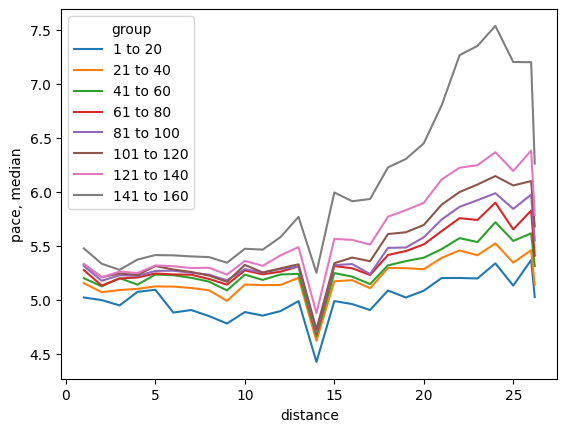

In [116]:
# Make a chart!

import seaborn as sns

df_chart = df_time_by_mile_by_group.reset_index()
df_chart = df_chart[df_chart['sex'] == 'M']

sns.lineplot(x="distance", y="pace, median",
             hue="group",
             data=df_chart)

In [117]:
df_results_clean_all[df_results_clean_all['name'] == 'Prescott Leach']

,name,sex,bib_display,label,place,placeChange,isFinish,distance,time,time_sec,time_min,splitTime,netTime,waveTime,epochTime,timestamp,flag_finished,last_distance,last_time,final_place
184,Prescott Leach,M,568,1M,156,NaN,NaN,1.0,00:05:29.83,329.83,5.497167,00:05:29.83,00:05:29.83,00:05:29.83,1706973328.52,1706955328.52,1,26.2,141.116667,71
381,Prescott Leach,M,568,2M,154,2,NaN,2.0,00:10:50.22,650.22,10.837000,00:05:20.39,00:10:50.22,00:10:50.22,1706973648.91,1706955648.91,1,26.2,141.116667,71
583,Prescott Leach,M,568,3M,156,-2,NaN,3.0,00:16:11.13,971.13,16.185500,00:05:20.91,00:16:11.13,00:16:11.13,1706973969.82,1706955969.82,1,26.2,141.116667,71
786,Prescott Leach,M,568,4M,159,-3,NaN,4.0,00:21:35.21,1295.21,21.586833,00:05:24.08,00:21:35.21,00:21:35.21,1706974293.90,1706956293.90,1,26.2,141.116667,71
981,Prescott Leach,M,568,5M,155,4,NaN,5.0,00:27:01.10,1621.10,27.018333,00:05:25.89,00:27:01.10,00:27:01.10,1706974619.79,1706956619.79,1,26.2,141.116667,71
1179,Prescott Leach,M,568,6M,153,2,NaN,6.0,00:32:20.54,1940.54,32.342333,00:05:19.44,00:32:20.54,00:32:20.54,1706974939.23,1706956939.23,1,26.2,141.116667,71
1374,Prescott Leach,M,568,7M,150,3,NaN,7.0,00:37:37.98,2257.98,37.633000,00:05:17.44,00:37:37.98,00:37:37.98,1706975256.67,1706957256.67,1,26.2,141.116667,71
1575,Prescott Leach,M,568,8M,152,-2,NaN,8.0,00:42:55.49,2575.49,42.924833,00:05:17.51,00:42:55.49,00:42:55.49,1706975574.18,1706957574.18,1,26.2,141.116667,71
1769,Prescott Leach,M,568,9M,148,4,NaN,9.0,00:48:07.77,2887.77,48.129500,00:05:12.28,00:48:07.77,00:48:07.77,1706975886.46,1706957886.46,1,26.2,141.116667,71
1967,Prescott Leach,M,568,10M,148,0,NaN,10.0,00:53:29.22,3209.22,53.487000,00:05:21.45,00:53:29.22,00:53:29.22,1706976207.91,1706958207.91,1,26.2,141.116667,71
